## Titanic's Passengers Survival Analysis

- **Dataset**: https://www.kaggle.com/datasets/yasserh/titanic-dataset/data


Column definitions:
- `PassengerId`: Passenger Id.
- `Survived`: Survival 
  - **0** = No 
  - **1** = Yes.
- `Pclass`: Ticket class
  - **1** = First class
  - **2** = Second class
  - **3** = Third class.
- `Name`: Passenger's name.
- `Sex`: Passenger's genre.
- `Age`: Passenger's age in years.
- `SibSp`: Number of sibligs / spouse aboard.
- `Parch`: Number of parents / children aboard.
- `Ticket`: Ticket number.
- `Fare`: Passenger's fare.
- `Cabin`: Cabin number.
- `Embarked`:  Port of embarkation
  - **C** = Cherbourg
  - **Q** = Queenstown
  - **S** = Southampton

## Libraries

In [1]:
%run 0.0-data_projects-setup.ipynb
%run pandas-missing-extension.ipynb

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
import janitor

# Missin Values Analysis
import missingno as msno

## Downdload and load data

Download dataset from kaggle:

In [3]:
from_kaggle("yasserh/titanic-dataset", "Titanic-Dataset.csv")

Dataset Titanic-Dataset.csv is already downloaded


Load and preview data:

In [4]:
df = pd.read_csv(path.data_raw_dir("Titanic-Dataset.csv"))
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


## Cleaning data

### Standarizing column names

In [6]:
df = df.clean_names(case_type="snake")
df.columns

Index(['unnamed_0', 'passenger_id', 'survived', 'pclass', 'name', 'sex', 'age',
       'sib_sp', 'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Drop unnecesary columns

Columns `passenger_id` and `unnamed_0` contain consecutive id values, besides columns `ticket` and `name` don't add valuable information to the analysis, so we can drop them.

In [7]:
df = df.drop(columns=["passenger_id", "unnamed_0", "ticket", "name"])

### Handling missing values

In [8]:
df.missing.missing_variable_summary().sort_values(by="pct_missing", ascending=False)

,variable,n_missing,n_cases,pct_missing
7,cabin,687,891,77.104377
3,age,177,891,19.865320
8,embarked,2,891,0.224467
0,survived,0,891,0.000000
1,pclass,0,891,0.000000
4,sib_sp,0,891,0.000000
2,sex,0,891,0.000000
6,fare,0,891,0.000000
5,parch,0,891,0.000000


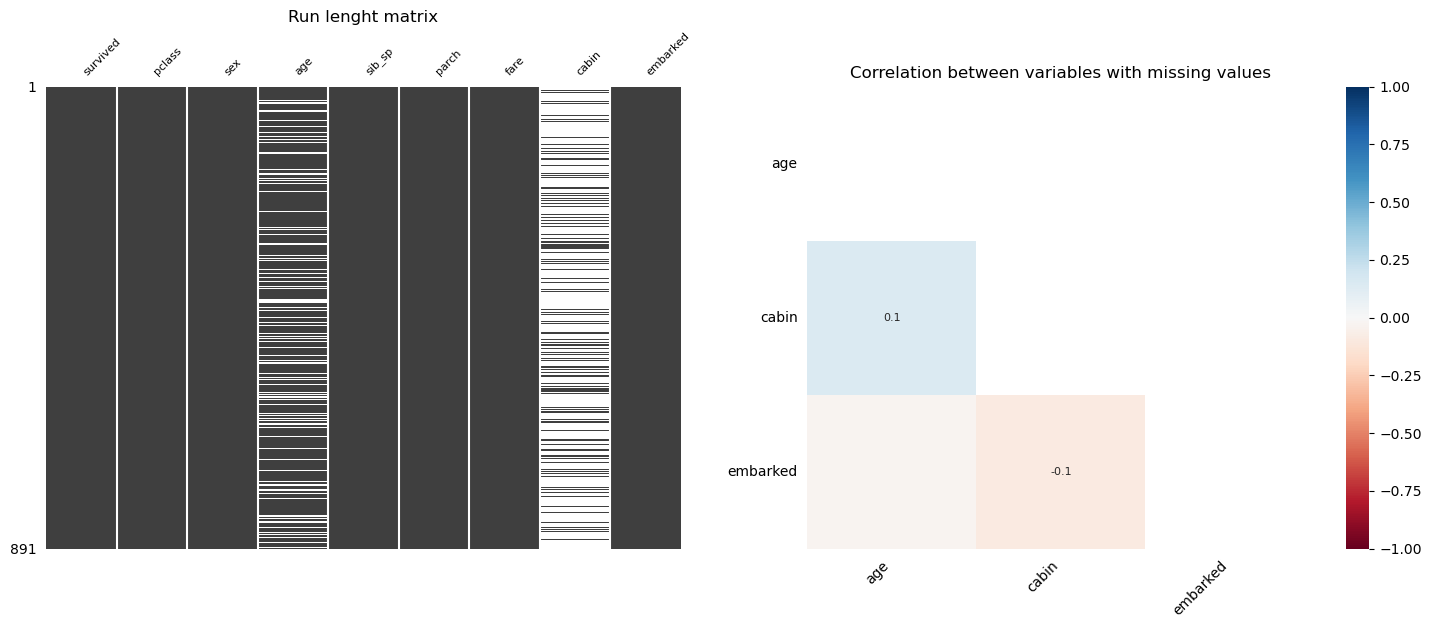

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))

msno.matrix(df=df, figsize=(8, 6), fontsize=8, ax=axes[0], sparkline=False)
axes[0].set_title("Run lenght matrix")

msno.heatmap(df, figsize=(8, 4), fontsize=10, ax=axes[1])
axes[1].set_title("Correlation between variables with missing values");

**Observations**
- According to the graphs above, there don't appear to be any patterns or corelations in the missing values.
- `embarked`'s null values represent only $0.22\%$ of data, so we can delete those rows or impute them with the most repeted value (mode).
- `age` column has 177 null values, deleting almost 20% of the observations could be counterproductive for this analysis. So, in this case, we can impute the median value by groups (grouped by `pclass`).
- The `cabin` column contains more null values than actual data. Therefore, it's more convinient exclude this variable from the analysis. However, we can create a new column called `has_cabin` to indicate whether a passenger has cabin information or not.


#### Imputing missing values

In [10]:
# Imputed embarked with the top.
top_embarked = df["embarked"].describe().top
df["embarked"] = df["embarked"].fillna(top_embarked)

# Creating new column, which indicates wheter a passenger has cabin information
df["has_cabin"] = df["cabin"].notnull().astype(int)
df.drop(columns=["cabin"], inplace=True)

`age` Imputation is performed by grouping passengers according to their `pclass`.

In [11]:
df["age"] = df.groupby(['pclass'])["age"].transform(lambda x: x.fillna(x.mean()))

In [12]:
df.isnull().sum().sum()

np.int64(0)

## Feature Engineering

A new feature `family_size`, was engineered by combining `sib_sp` and `parch`. This variable may reveal important insights releted to survival rates and passengers group dynamics.

In [13]:
df["family_size"] = df["sib_sp"]+df["parch"]
df[df["family_size"]>1].head()

,survived,pclass,sex,age,sib_sp,parch,fare,embarked,has_cabin,family_size
7,0,3,male,2.0,3,1,21.0750,S,0,4
8,1,3,female,27.0,0,2,11.1333,S,0,2
10,1,3,female,4.0,1,1,16.7000,S,1,2
13,0,3,male,39.0,1,5,31.2750,S,0,6
16,0,3,male,2.0,4,1,29.1250,Q,0,5


The `age_group` feature categorizes passengers into age-based groups. This enginereed variabel can calp uncover patterns in survival rates and provide a deeper understanding of demographic trends among passengers.

In [14]:
df['age_group'] = pd.cut(df["age"], bins=[0, 18, 35, 65, float("inf")], labels=["Child", "Young", "Adult", "Senior"])

## Analysis

In [15]:
display(df.describe(), df.describe(include="object"))

,survived,pclass,age,sib_sp,parch,fare,has_cabin,family_size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.292875,0.523008,0.381594,32.204208,0.228956,0.904602
std,0.486592,0.836071,13.210527,1.102743,0.806057,49.693429,0.420397,1.613459
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,10.000000


,sex,embarked
count,891,891
unique,2,3
top,male,S
freq,577,646


In [16]:
sns.set_style(style='whitegrid')

### Numerical Variables Distribution

In [17]:
def distribution_plots(df_data, col, xlabel="", ylabel=""):
	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
	fig.suptitle(f"{col.capitalize()} Distribution")

	q1 = df_data[col].quantile(.25)
	q3 = df_data[col].quantile(.75)
	IQR = q3 - q1
	high_iqr = q3 + (IQR * 1.5)
	low_iqr = q1 -(IQR * 1.5)

	# Histogram
	sns.histplot(data=df_data, x=col, ax=axes[0], kde=True, bins=50)
	axes[0].set_xlabel(xlabel)
	axes[0].set_ylabel("Frequency")

	axes[0].axvline(
		x=high_iqr,
		color="orange",
		linestyle="--"
	)
 
	axes[0].axvline(
		x=low_iqr,
		color="orange",
		linestyle="--"
	)

	# Boxplot
	sns.boxplot(data=df_data, y=col, ax=axes[1])
	axes[1].set_xlabel(xlabel)
	axes[1].set_ylabel(ylabel)

	axes[1].axhline(
		y=high_iqr,
		color="orange",
		linestyle="--"
	)
 
	axes[1].axhline(
		y=low_iqr,
		color="orange",
		linestyle="--"
	)

	# Violint plot
	sns.violinplot(data=df_data, y=col, ax=axes[2])
	sns.stripplot(data=df_data, y=col, ax=axes[2], alpha=.3)
	axes[2].set_xlabel(xlabel)
	axes[2].set_ylabel(ylabel)

	plt.tight_layout()
	plt.show()
	print(f"Values over {high_iqr} and under {low_iqr}, are considered outliers.")

Age Distribution

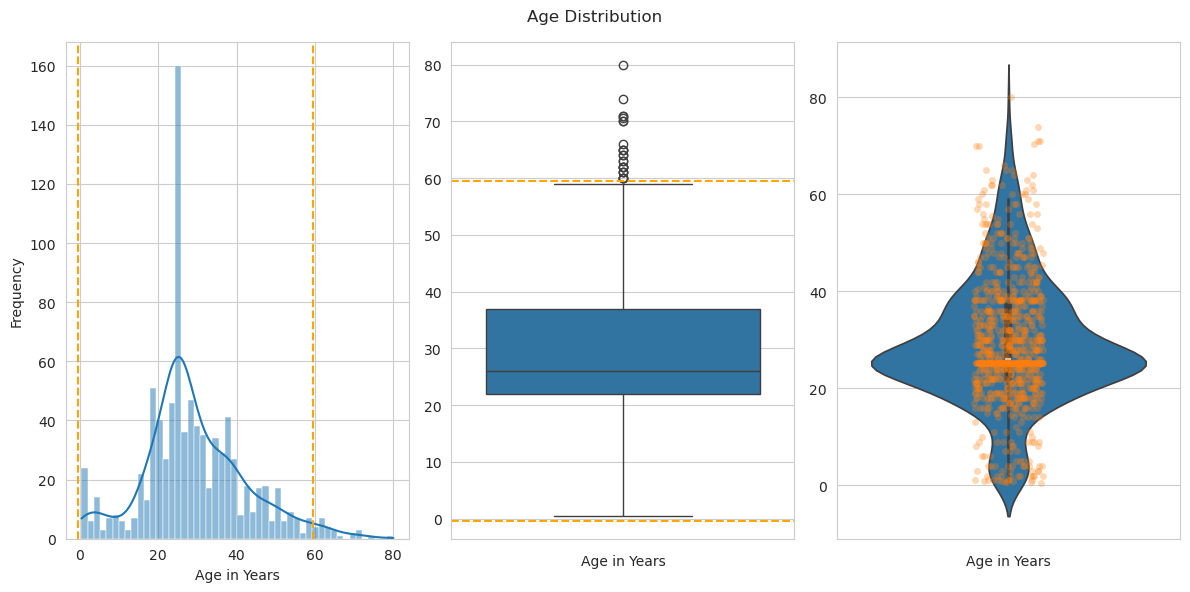

Values over 59.5 and under -0.5, are considered outliers.


In [18]:
distribution_plots(df, "age", xlabel="Age in Years")

**Obserbations**
- Overall, most passenger were youg adults, primarly in their 20s and 40s.
- There is a noticeable concentration arund age 25, which aligns with the mean. This pattern is likely influence by the age imputation performed earlier using the mean value.
- In general, the age distribution is approximately normal, with a few outliers.

Fare Distribution

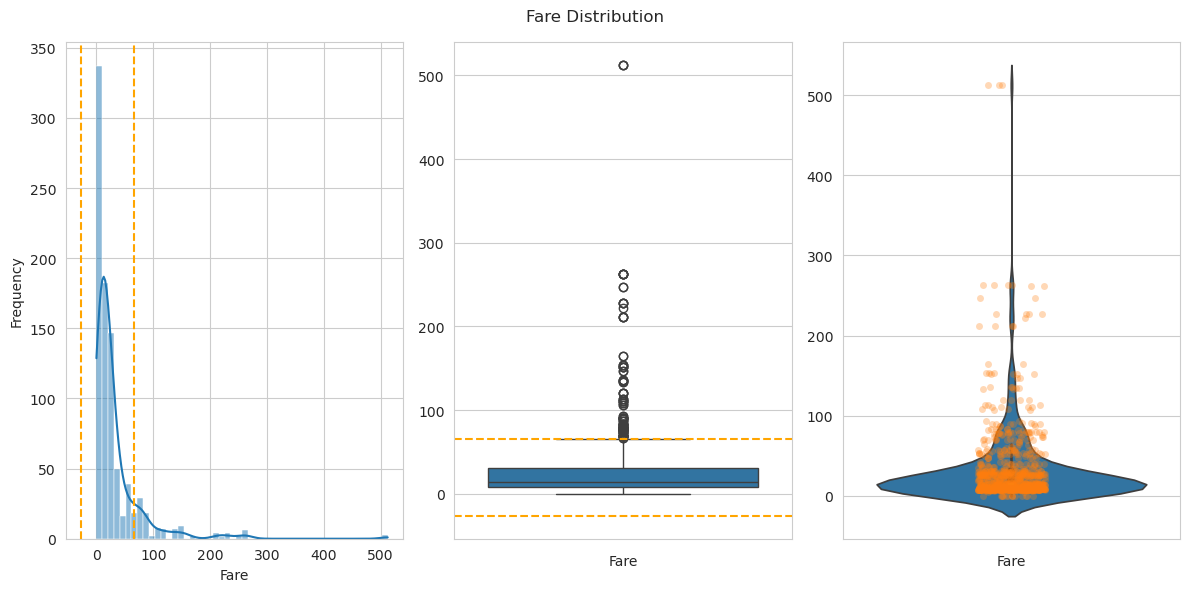

Values over 65.6344 and under -26.724, are considered outliers.


In [19]:
distribution_plots(df, "fare", xlabel="Fare", ylabel="")

**Observations**
- Fare values are highly concentrated below 65 sterling per ticket. This may suggests is correlated with the large number of passengers who traveled in 2nd and 3rd class.
- On the other hand, fares avobe 65 sterling likely correspond to first-class passengers.These higher ticket prices may include the cost of a private cabin, which could explain the extreme fares exceeding 500 sterling.
- This distribution shows right skewness, with a small number of extremely high fares.

#### Family Distribution

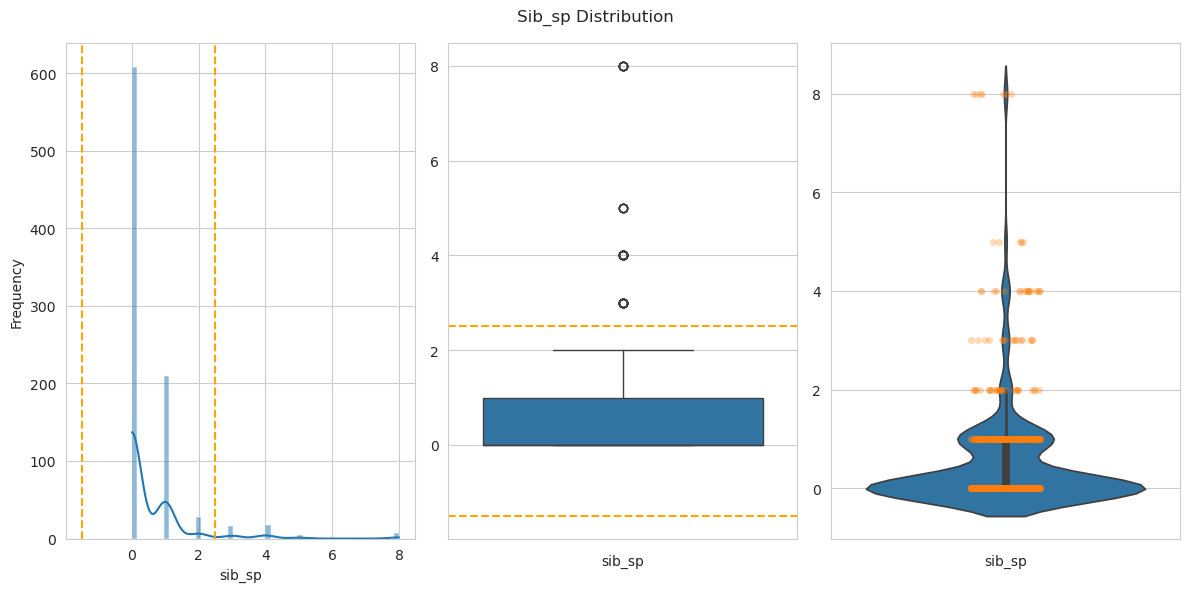

Values over 2.5 and under -1.5, are considered outliers.


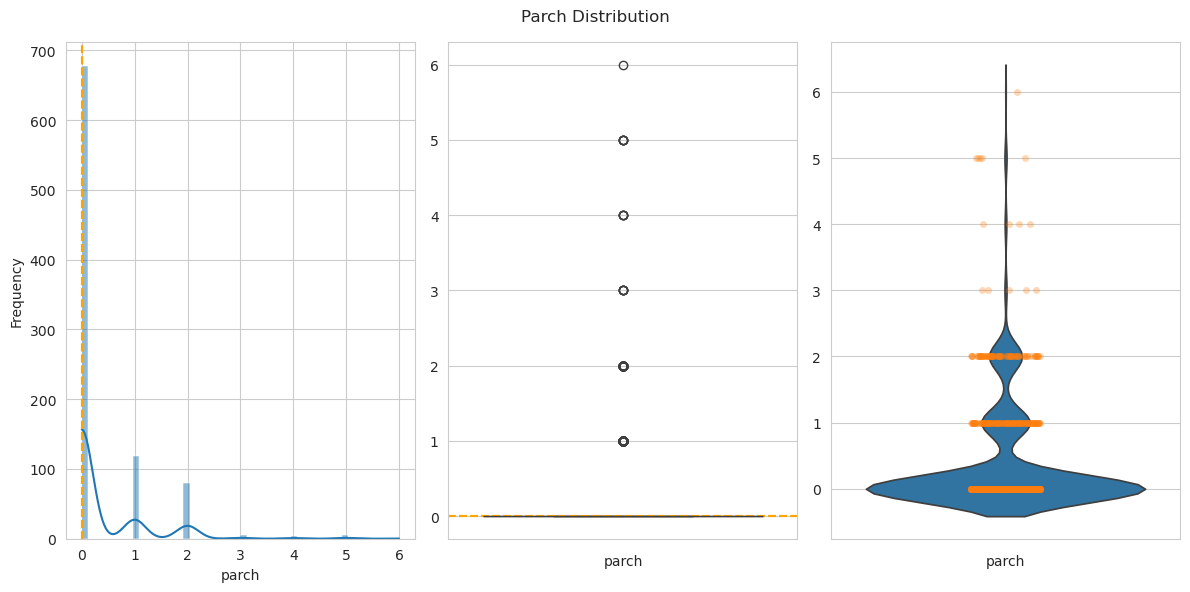

Values over 0.0 and under 0.0, are considered outliers.


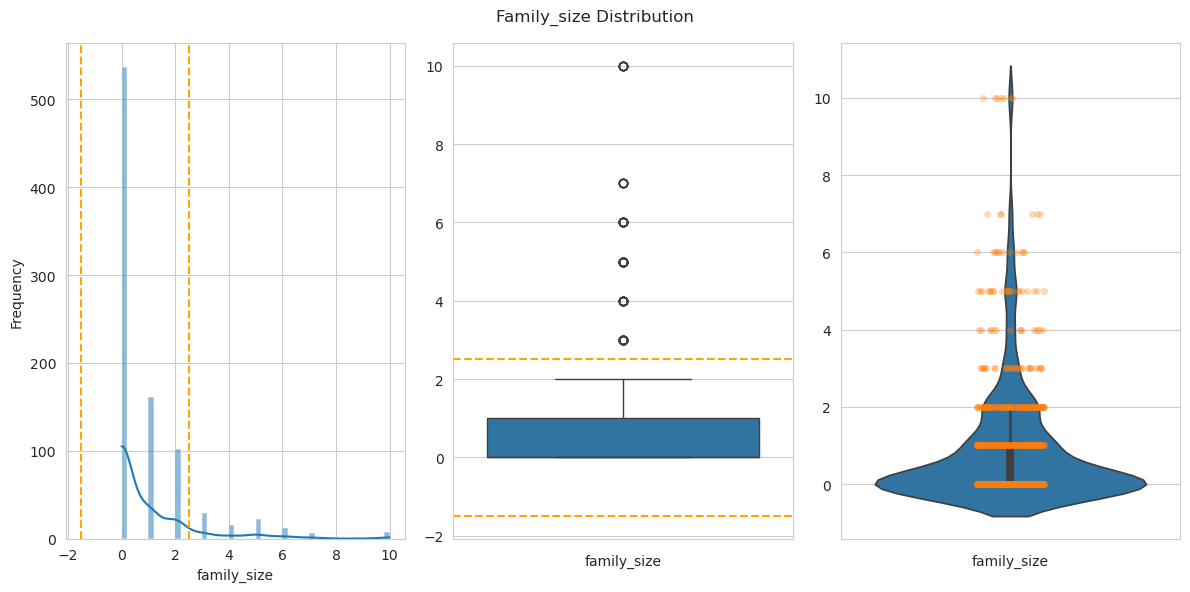

Values over 2.5 and under -1.5, are considered outliers.


In [20]:
num_cols = ["sib_sp", "parch", "family_size"]

for col in num_cols:
	distribution_plots(df, col, xlabel=col, ylabel="")

**Observations**
- Most passenger traveled alone, while a smaller portion traveled with a spouse. Based on the age distribution, these may have been young couples.
- A limited number of passengers were accompainied by family members such as siblings, parents or children.

### Categorical Proportions

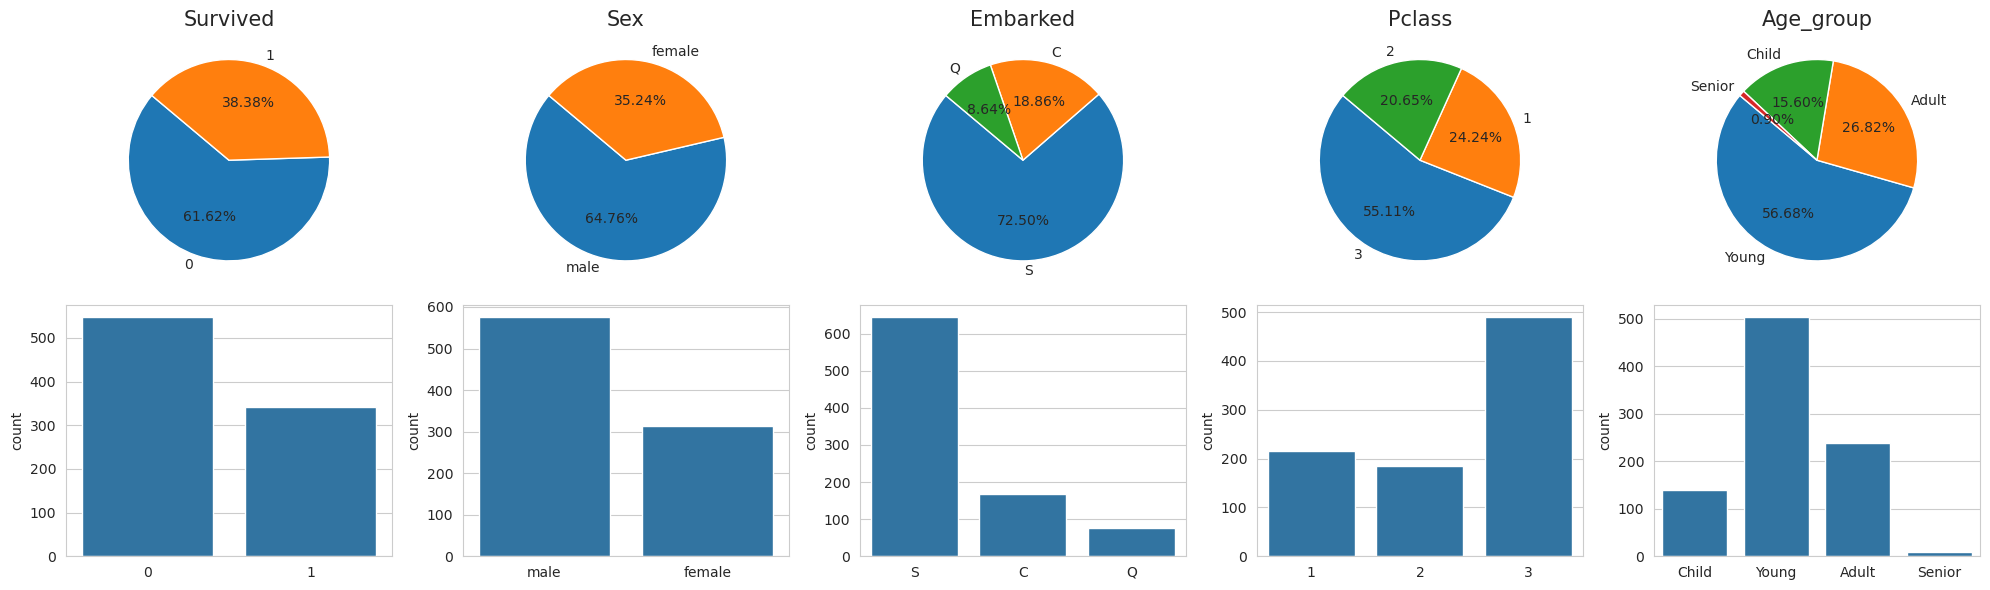

In [21]:
categorical_cols = ["survived", "sex","embarked", "pclass","age_group"]
fig, axes = plt.subplots(nrows=2, ncols=len(categorical_cols), figsize=(20,6))

for i, col in enumerate(categorical_cols):  
  counts = df[col].value_counts().reset_index(name="count")  
  
  axes[0, i].pie(
    data=counts, 
    x="count",
    autopct="%1.2f%%",
    startangle=140,
    labels=counts[col]
  )
  axes[0, i].set_title(f"{col.capitalize()}", fontdict={'fontsize': 15})
  
  sns.countplot(
		data=df,
  	x=col,
   ax=axes[1, i]
	)
  axes[1, i].set_xlabel("")
	
plt.tight_layout()

**Observations**
- Based on the proportion graph above, approximately $38.38\%$ of survivors appear to be predomiantly young male passengers from 3rd class. This may be due to the higher number of passengers with these characteristics in the dataset.

But, Is that true?, so lets dive deeper!

### Survival Rate

In [22]:
def survival_plot(variable, ax=None):
	sns.countplot(
		data=df,
		x=variable,
		hue="survived",
		ax=ax
	)

	if not ax:
		plt.title(f"Survived by {variable.capitalize()}")
		plt.xlabel(variable.capitalize())
		plt.ylabel("Number of Passengers")
		plt.legend(title="", labels=["Not Survived", "Survived"])
	else:
		ax.set_title(f"Survived by {variable.capitalize()}")
		ax.set_xlabel(variable.capitalize())
		ax.set_ylabel("Number of Passengers")
		ax.legend(title="", labels=["Not Survived", "Survived"])

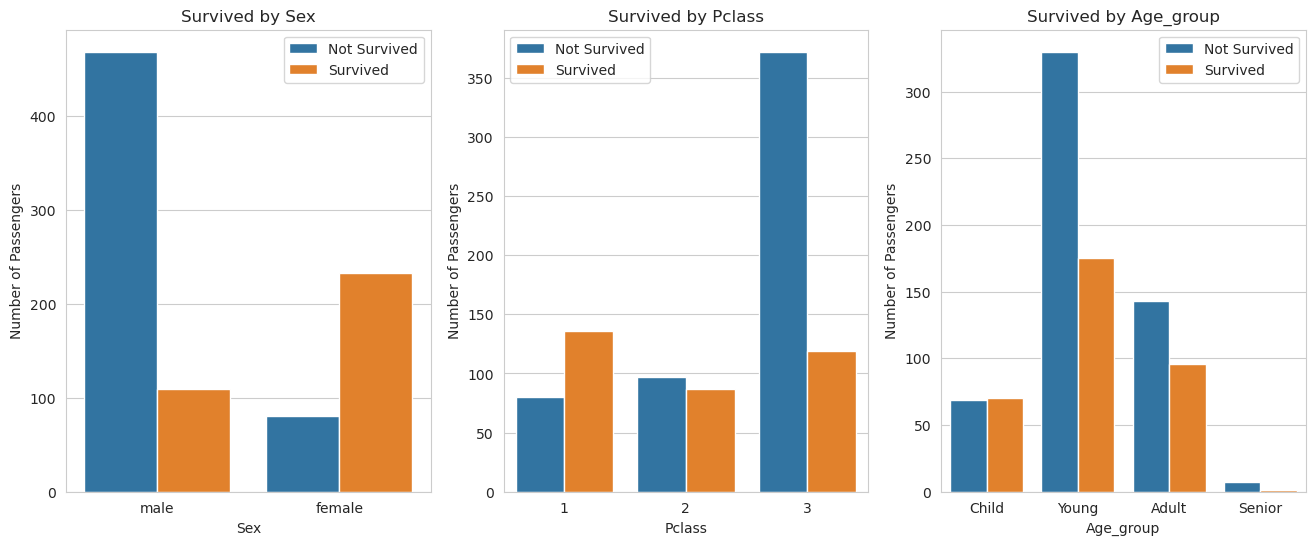

In [23]:
variables = ["sex", "pclass", "age_group"]

fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(16, 6))

for var, ax in zip(variables, axes):
	survival_plot(var, ax)
	survival_rate = df.groupby(var, observed=False)["survived"].mean() * 100

In [24]:
for var in variables:
	print("="*15, f"Survival rate by {var}", "="*15)
	survival_rate = df.groupby(var, observed=False)["survived"].mean()*100
	for i in range(len(survival_rate)):
		print(f"{survival_rate.index[i]}: {survival_rate.iloc[i]:.2f}%")

=============== Survival rate by sex ===============
female: 74.20%
male: 18.89%
=============== Survival rate by pclass ===============
1: 62.96%
2: 47.28%
3: 24.24%
=============== Survival rate by age_group ===============
Child: 50.36%
Young: 34.65%
Adult: 40.17%
Senior: 12.50%


/home/pahoalapizco/anaconda3/envs/data_projects/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pahoalapizco/anaconda3/envs/data_projects/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 63.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pahoalapizco/anaconda3/envs/data_projects/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 82.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pahoalapizco/anaconda3/envs/data_projects/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

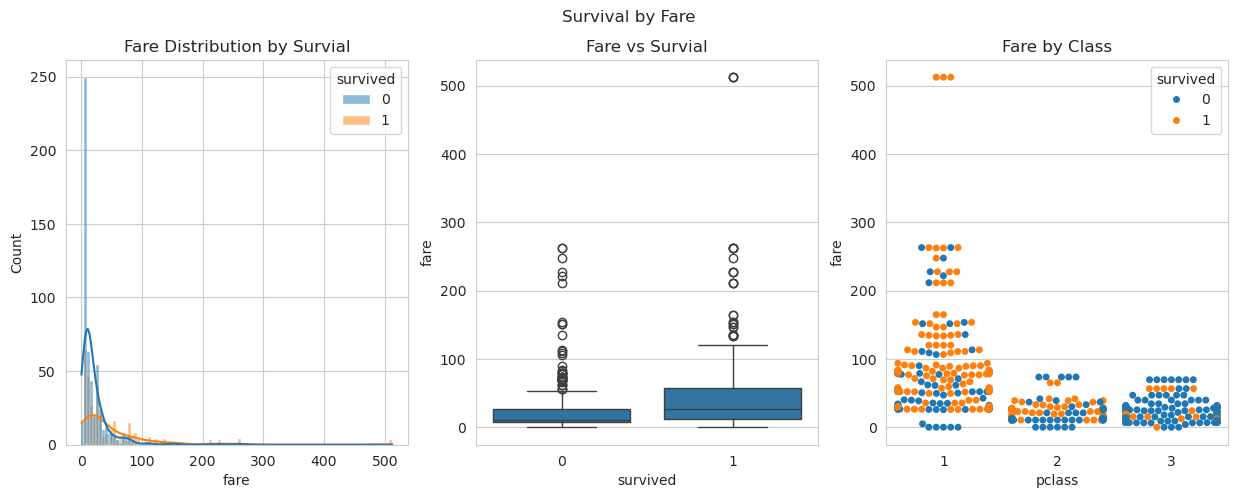

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle("Survival by Fare")

sns.histplot(
	data=df,
	x="fare",
	hue="survived",
	kde=True,
	ax=axes[0]
)
axes[0].set_title("Fare Distribution by Survial")
sns.boxplot(
	data=df,
	x="survived",
	y="fare",
	ax=axes[1]
)
axes[1].set_title("Fare vs Survial")

sns.swarmplot(
	data=df,
	x="pclass",
	y="fare",
	hue="survived",
	ax=axes[2]
)
axes[2].set_title("Fare by Class");

**Observations** <br>
Based on the survival rate and previous visualizations:
- $74\%$ of the women onboard survided, compared to 19% of the male passengers.
- Third-class passengers were significantly disadvantaged, with over $75\%$ failing to survived, suggested they had limited access to lifeboats.
- First-class with the most expensive tickets had a clear advantage, likely receiving priority access to lifeboats over those in second and third class.
- Children had a $50\%$ chance of survival, which, while higher than most adults, stills reflects the overall chaos and limitations of the evacuations process.


Based on these observations, we can infer that gender, class and age have a significant influence on survival. To validate this assumption, we can apply `chi-square` test to these variables.

In [ ]:
from scipy.stats import chi2, chi2_contingency

def chisquare_test(contingency_table):
	chi_2, p, dof, _ = chi2_contingency(contingency_table)
	print("Contingency table")
	print(contingency_table)
	print(f"\nChi-Square {chi_2}")
	print(f"p-value {p}")
	print(f"Degrees of Freedom {dof}")

	x = np.linspace(0, chi_2+30, 500) # Possible range of chi2
	y = chi2.pdf(x, dof) # Probability density function

	# Critical value for a significance level of 5%
	cv = chi2.ppf(0.95, dof)

	# Visualizing the distribution
	plt.figure(figsize=(10,6))
	plt.plot(x, y, label=f"$Chi^2$ Distribution (dof={dof})")
	plt.axvline(chi_2, color="red", linestyle="--", label=f"$Chi^2$ = {chi_2:.3f}")
	plt.axvline(cv, color="green", linestyle=":", label=f"$Critical Value$ (p=0.05) = {cv:.3f}")
	plt.fill_between(x, y, where=(x > cv), color="orange", alpha=0.5, label="$H_0$ Rejected Zone")
	plt.legend()
	plt.title("$Chi^2$ Distribution")
	plt.xlabel("$Chi^2$ Value")
	plt.ylabel("Probability Density")
	plt.grid(True)
	plt.tight_layout()
	plt.show()


- $H_0$ for `sex`: There is no relation between sex and survival.
- $H_1$ for `sex`: There is a relation.

Contingency table
survived    0    1
sex               
female     81  233
male      468  109

Chi-Square 260.71702016732104
p-value 1.1973570627755645e-58
Degrees of Freedom 1


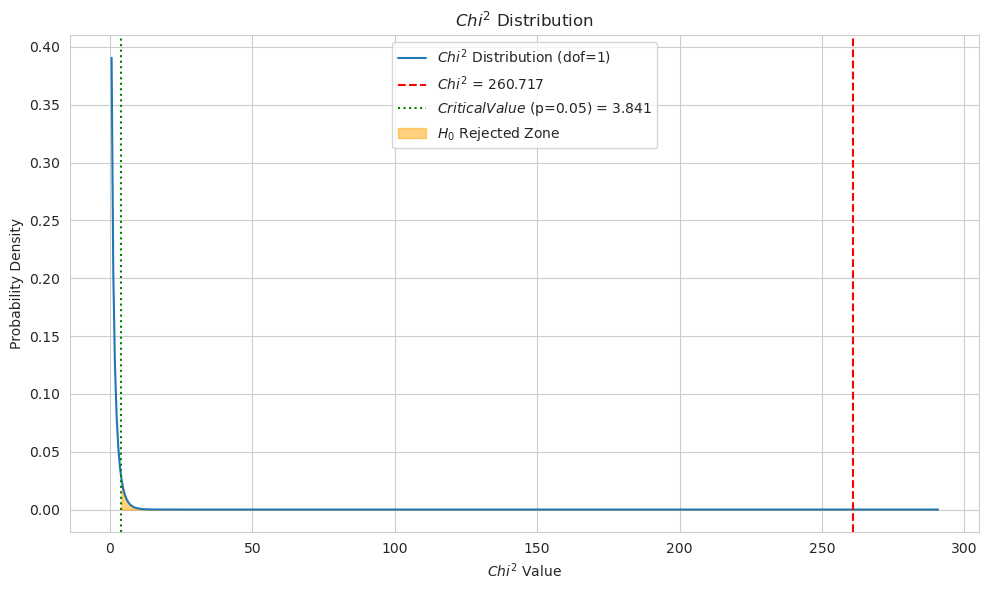

In [26]:
survival_by_sex = pd.crosstab(
	index=df["sex"],
	columns=df["survived"]
)

chisquare_test(survival_by_sex)

- $H_0$ for `pclass`: There is no relation between class and survival.
- $H_1$ for `pclass`: There is a relation.

Contingency table
survived    0    1
pclass            
1          80  136
2          97   87
3         372  119

Chi-Square 102.88898875696056
p-value 4.549251711298793e-23
Degrees of Freedom 2


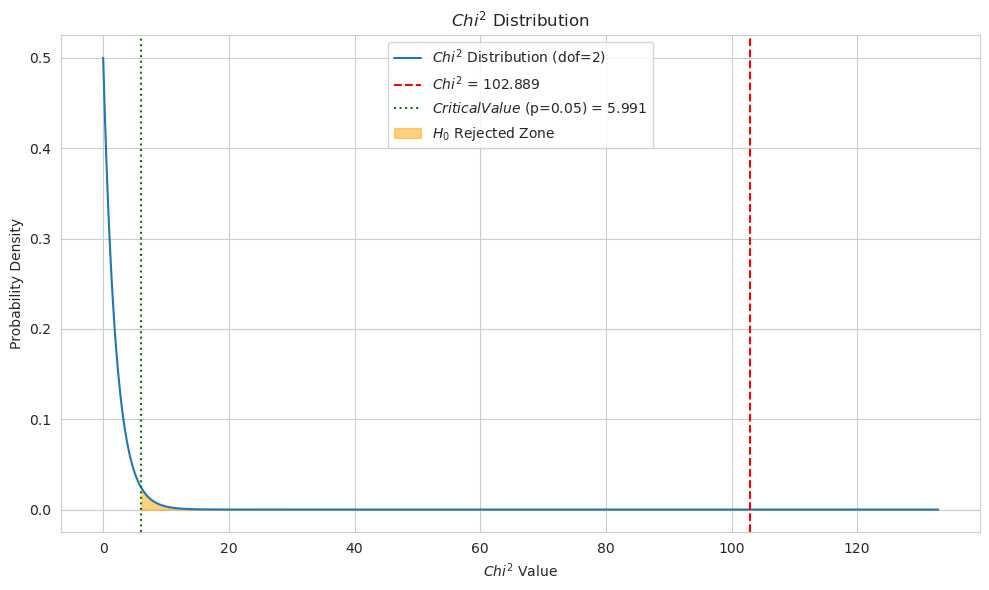

In [27]:
survival_by_class = pd.crosstab(
	index=df["pclass"],
	columns=df["survived"]
)

chisquare_test(survival_by_class)

- $H_0$ for `age_group`: There is no relation between age and survival.
- $H_1$ for `age_group`: There is a relation.

Contingency table
survived     0    1
age_group          
Child       69   70
Young      330  175
Adult      143   96
Senior       7    1

Chi-Square 13.988221869792753
p-value 0.002921228738406372
Degrees of Freedom 3


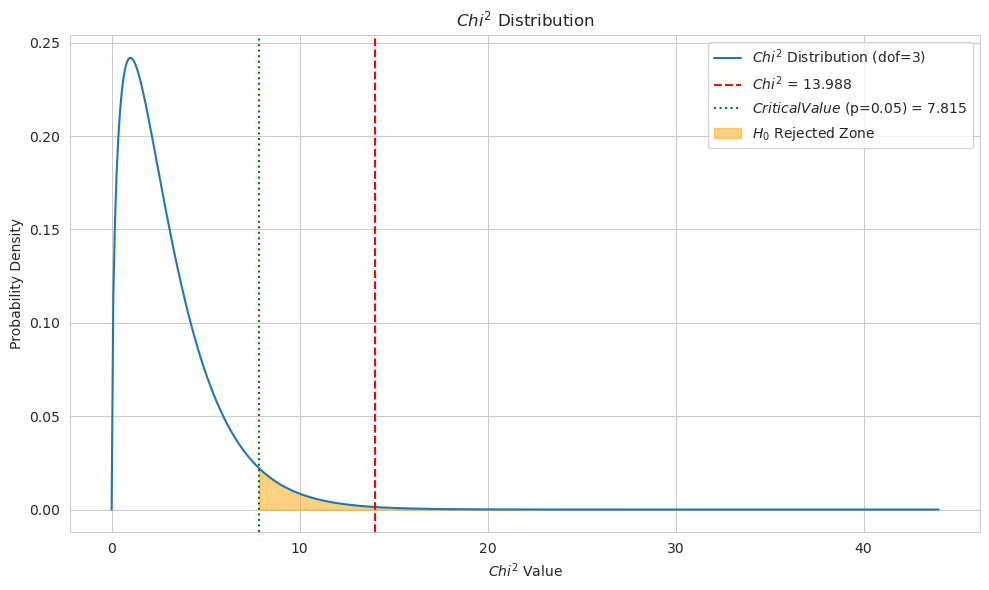

In [28]:
survival_by_age = pd.crosstab(
	index=df["age_group"],
	columns=df["survived"]
)

chisquare_test(survival_by_age)

For all three variable, our null hypotheses ($H_0$) stated that there is no association with sirvival. However, based on the results of chi-square tests, we rejected each null hypothesis. All p-values were below the 0.05 significace level, and each chi-square statistic exceeded the corresponding critical value. Therefore, we can conclude that sex, age and class have a statistically significant relationship with survival.



> 💡 The survival data from Titanic strongly reflects the _"women and children first"_ principle. The survival rate for women was dramatically higher than for men, and children had better odds than most adults. <br> However, the data also revels how class differences influenced this policy's excecutions: while many first-class women survived, third-class passengers regardless of age or gender were far less likely to reach lifeboats. This highlights how to access to safety was shaped not just by gender or age, but also socioeconomic status.

## Conclusions

The analysis of the Titanic dataset reveals strong patterns in passenger demographics, ticket pricing, family relationships, and survival outcomes. Most passengers were young adults, with a significant concentration around age 25, likely influenced by mean-based age imputation.

A small group of first-class passengers paid significantly higher fares, likely due to the inclusion of private cabins, with some tickets exceeding 500 sterling.

In terms of travel companionship, most individuals boarded alone, while a smaller number were accompanied by a spouse or family members, suggesting the presence of young couples and small family groups.

Survival outcomes showed clear disparities. Women had a survival rate of $74\%$, while only $19\%$ of men survived. First-class passengers were far more likely to survive compared to those in second or third class, reinforcing the role of social class in evacuation procedures. Children had a $50\%$ chance of survival, indicating partial adherence to the “women and children first” principle, though this was limited by overall evacuation conditions.

Finally, statistical testing using chi-square analysis confirmed that sex, age, and passenger class all had a statistically significant association with survival (p < 0.05 for all variables). These findings emphasize how survival aboard the Titanic was not random, but rather deeply influenced by demographics and social class.